# Forecasting Lottery Numbers

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.pyplot import figure
import seaborn as sns

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

In [8]:
df = pd.read_csv("powerball_numbers.csv")
print(f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

Dataset has 144 rows and 9 columns.


In [9]:
df.index=df['date']
df=df.drop(['date'], axis=1)

In [10]:
df=df.iloc[::-1]

In [11]:
df

,num1,num2,num3,num4,num5,num6,num7,num8
date,,,,,,,,
19/04/2018,9,5,32,13,33,4,25,7
26/04/2018,14,35,34,15,24,19,9,12
3/05/2018,19,20,6,1,24,3,16,13
10/05/2018,6,24,15,14,26,32,35,14
17/05/2018,9,26,16,34,3,31,25,9
...,...,...,...,...,...,...,...,...
17/12/2020,29,4,17,16,33,5,9,13
24/12/2020,12,9,21,4,11,32,29,2
31/12/2020,1,11,28,2,7,2,16,7


## Adding Analytical Figures

- Sequential Pairs (SP): denotes how many pairs of sequential numbers are there in a particular draw, e.g. the draw (10, 11, 20, 27, 28, 30, 31) has an SP of 3, being (10, 11), (27, 28) and (30, 31).
- Odd Even Ratio (OE): denotes the ratio of odd and even numbers in a draw, e.g. the draw (10, 11, 20, 27, 28, 30, 31) has an OE of 3:4, there are 3 odd numbers and 4 even numbers.
- Small Big Ratio (SB): denotes the ratio of numbers that belong to upper half and lower half, within the possible number range. e.g. PowerBall has a range of 1 to 35 for its main matrix, so let’s say Small range is 1-17 and Big range is 18-35, thus the draw (10, 11, 20, 27, 28, 30, 31) has a BS of 5:2
- Three Partition Ratio (3P): dividing the range of possible numbers into three partitions, for PowerBall, they are 1-12, 13-24 and 25-35, 3P denotes the number of balls that belong to each partition. For the draw (10, 11, 20, 27, 28, 30, 31), its 3P is 214.
- Head Tail Distance (HTD): the distance between the smallest number and the largest number in a single draw, for the draw (10, 11, 20, 27, 28, 30, 31), its HTD is 21.


- Arithmetic Complexity (AC): the complexity of a draw, it’s calculated in such a way:


1. Calculate the absolute difference between every two numbers in a draw.
2. Eliminate the same numbers from result of 1, let D be the remaining number of differences.
3. AC = D - (r - 1), r is the number of numbers in a draw

In [12]:
df['numString'] = df.values.tolist()

## Adding Sequential Pairs

In [13]:
sequential_pairs=[]

for prac in df['numString'].tolist():
    consec = []
    del prac[-1]
    for k in prac:
        for j in prac:
            if j==k:
                continue
            elif k+1==j or k-1==j:
                temp=[k,j]
                temp=tuple(sorted(temp))
                consec.append(temp)
    sequential_pairs.append(len(set(consec)))

In [14]:
df['SP']=sequential_pairs

### Adding Odd-Even Ratio

In [15]:
OE_list = []
for prac in df['numString'].tolist():
    even_count=0
    odd_count=0
    for k in prac:
        if k%2 ==0:
            even_count+=1
        else:
            odd_count+=1
    OE_ratio=odd_count/even_count
    OE_list.append(OE_ratio)

In [16]:
df['OE']=OE_list

### Adding Small-Big Ratio

In [17]:
SB_list = []
for prac in df['numString'].tolist():
    small_count=0
    big_count=0
    for k in prac:
        if k<18:
            small_count+=1
        else:
            big_count+=1
    try:
        SB_ratio=small_count/big_count
    except:
        SB_ratio=7
    SB_list.append(SB_ratio)

In [18]:
df['SB']=SB_list

### Adding 3-Partition Count

In [19]:
P1_list = []
P2_list = []
P3_list = []
for prac in df['numString'].tolist():
    small_count=0
    mid_count=0
    big_count=0
    for k in prac:
        if k<13:
            small_count+=1
        elif k>12 and k<25:
            mid_count+=1
        else:
            big_count+=1
    P1_list.append(small_count)
    P2_list.append(mid_count)
    P3_list.append(big_count)

In [20]:
df['P1']=P1_list
df['P2']=P2_list
df['P3']=P3_list

### Adding Head-Tail Distance

In [21]:
# df['HTD']=df['num7']-df['num1']

HTD_list = []
for prac in df['numString'].tolist():
    min_vals=min(prac)
    max_vals=max(prac)
    HTD_val=max_vals-min_vals
    HTD_list.append(HTD_val)

df['HTD']=HTD_list

### Adding Arithmetic Complexity

In [22]:
AC_list = []
for prac in df['numString'].tolist():
    diff_list = []
    for k in prac:
        for j in prac:
            if j==k:
                continue
            else:
                diff=abs(k-j)
                diff_list.append(diff)

    diff_list=set(diff_list)
    diff_length=len(diff_list)
    ac_value= diff_length-6
    AC_list.append(ac_value)

In [23]:
df['AC']=AC_list

In [24]:
df

,num1,num2,num3,num4,num5,num6,num7,num8,numString,SP,OE,SB,P1,P2,P3,HTD,AC
date,,,,,,,,,,,,,,,,,
19/04/2018,9,5,32,13,33,4,25,7,"[9, 5, 32, 13, 33, 4, 25]",2,2.500000,1.333333,3,1,3,29,10
26/04/2018,14,35,34,15,24,19,9,12,"[14, 35, 34, 15, 24, 19, 9]",2,1.333333,0.750000,1,4,2,26,8
3/05/2018,19,20,6,1,24,3,16,13,"[19, 20, 6, 1, 24, 3, 16]",1,0.750000,1.333333,3,4,0,23,10
10/05/2018,6,24,15,14,26,32,35,14,"[6, 24, 15, 14, 26, 32, 35]",1,0.400000,0.750000,1,3,3,29,9
17/05/2018,9,26,16,34,3,31,25,9,"[9, 26, 16, 34, 3, 31, 25]",1,1.333333,0.750000,2,1,4,31,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17/12/2020,29,4,17,16,33,5,9,13,"[29, 4, 17, 16, 33, 5, 9]",2,2.500000,2.500000,3,2,2,29,9
24/12/2020,12,9,21,4,11,32,29,2,"[12, 9, 21, 4, 11, 32, 29]",1,1.333333,1.333333,4,1,2,28,11
31/12/2020,1,11,28,2,7,2,16,7,"[1, 11, 28, 2, 7, 2, 16]",1,0.750000,6.000000,5,1,1,27,7


### Absolute Difference Between Numbers of the Draw Order

In [25]:
df['num1-num2']=abs(df['num1']-df['num2'])
df['num2-num3']=abs(df['num2']-df['num3'])
df['num3-num4']=abs(df['num3']-df['num4'])
df['num4-num5']=abs(df['num4']-df['num5'])
df['num5-num6']=abs(df['num5']-df['num6'])
df['num6-num7']=abs(df['num6']-df['num7'])

In [20]:
# sorted(df['num8'].unique())

In [21]:
# sequential_pairs=[]
# prac=[4, 5, 9, 13, 25, 32, 33]

# AC_list = []
# diff_list = []
# for k in prac:
#     for j in prac:
#         if j==k:
#             continue
#         else:
#             diff=abs(k-j)
#             diff_list.append(diff)

# diff_list=set(diff_list)
# diff_length=len(diff_list)
# ac_value= diff_length-6
# AC_list.append(ac_value)

# AC_list



In [22]:
# len(np.where((df['num1'] == 1))[0])

#df['SP']=df[]

## Explorartory Data Analysis

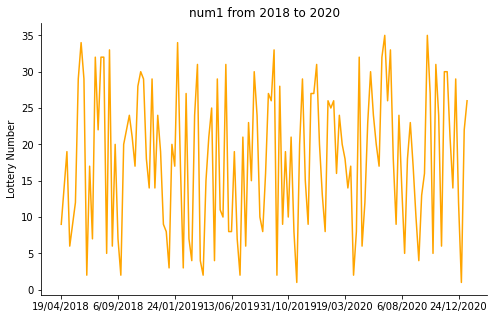

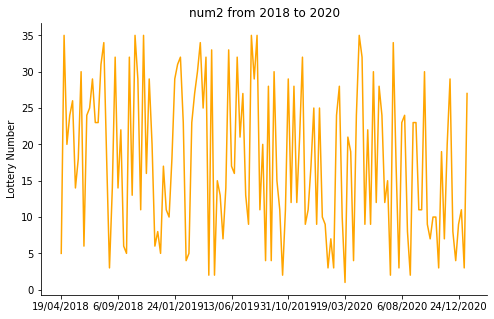

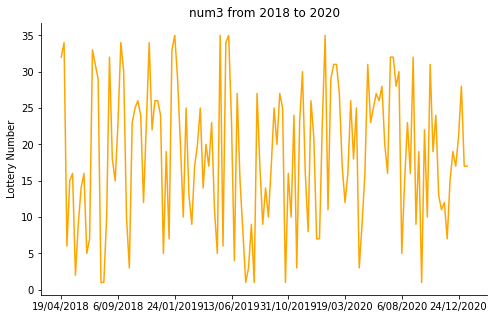

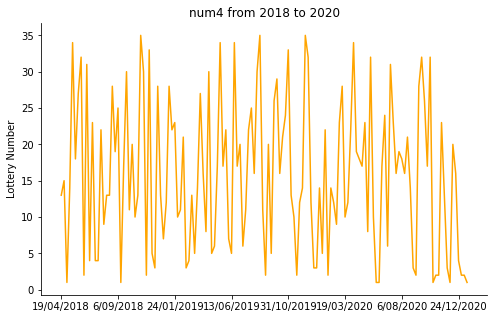

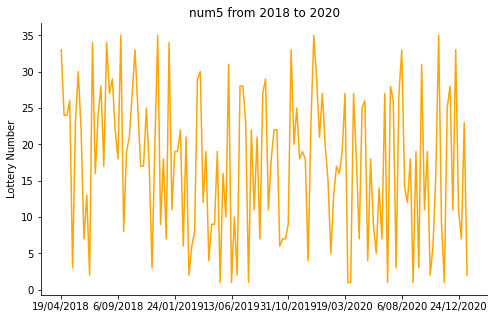

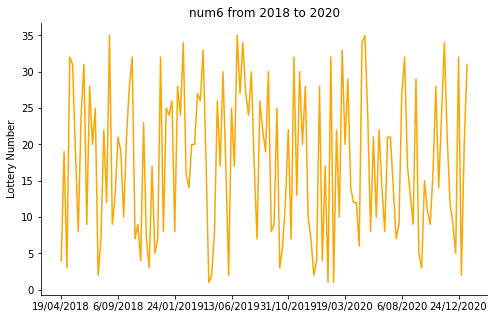

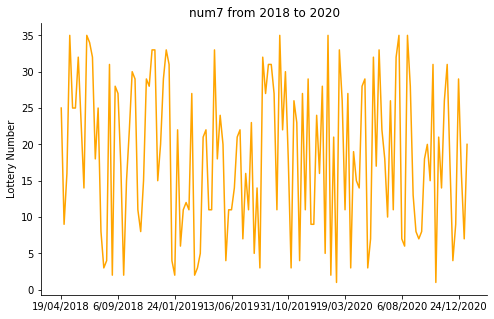

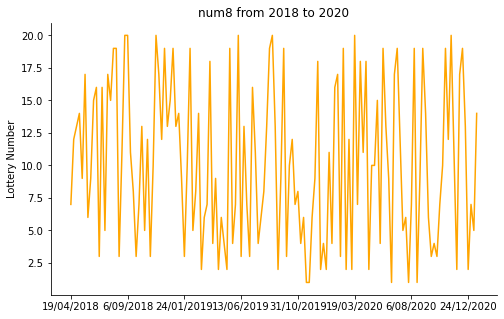

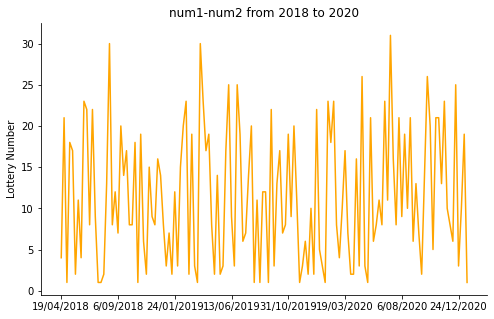

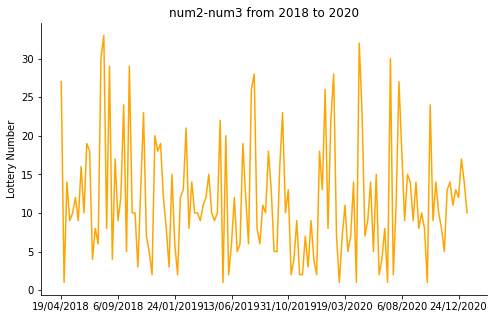

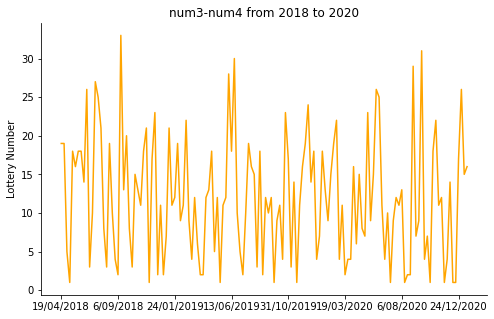

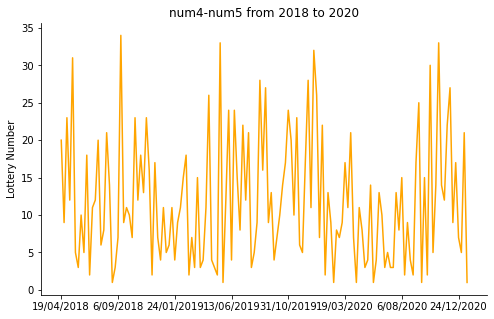

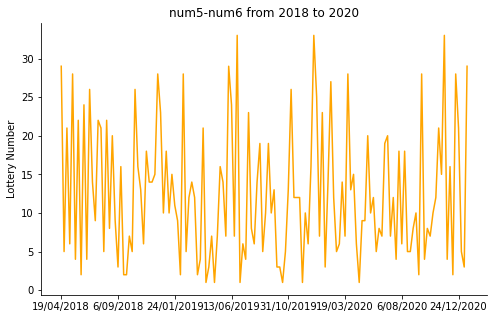

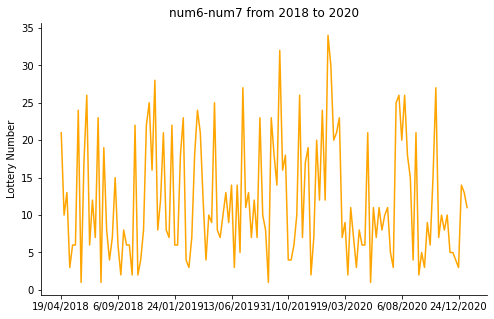

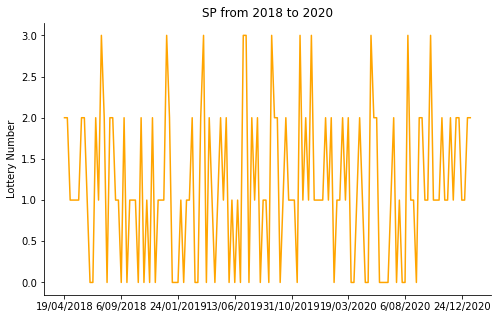

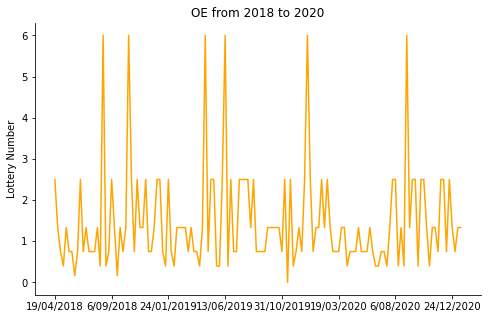

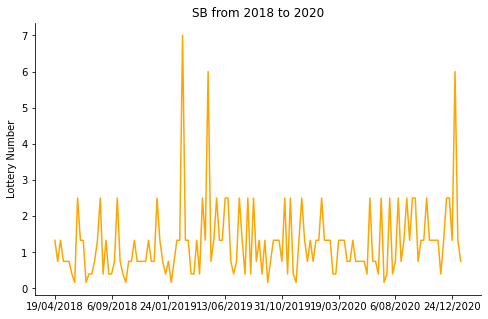

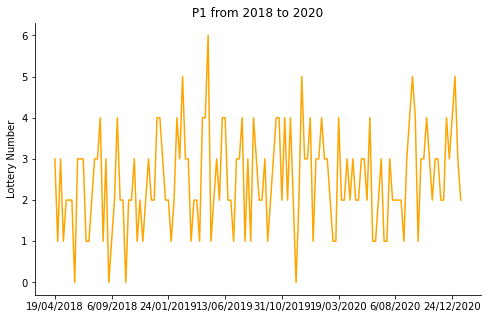

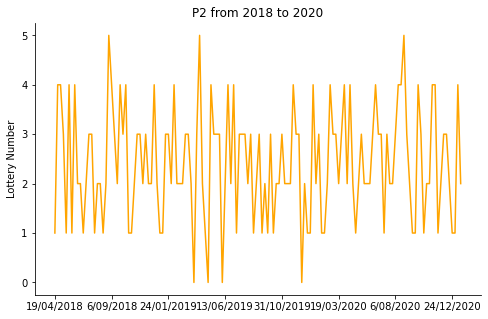

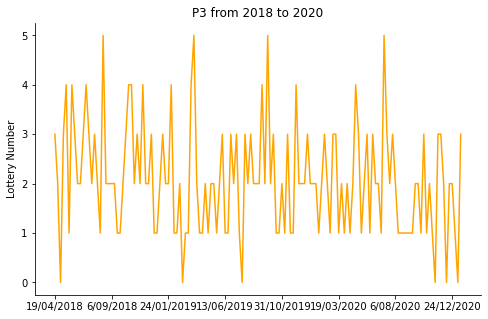

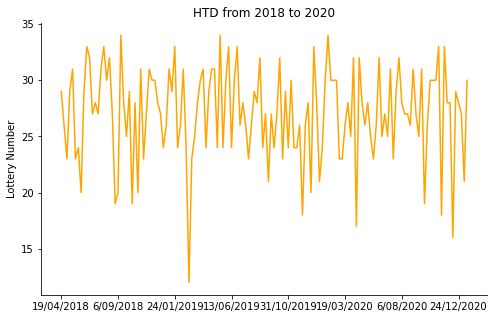

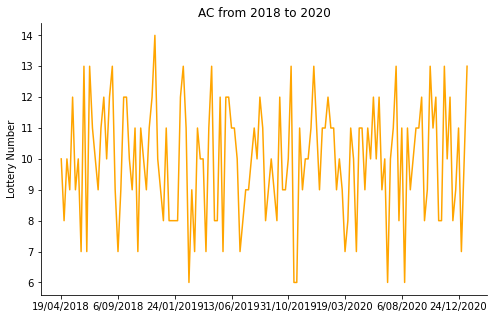

In [27]:
cols = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8',
        'num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6',
        'num6-num7', 'SP', 'OE', 'SB', 'P1', 'P2', 'P3', 'HTD', 'AC']

for i in cols:
    y=df[i]
    fig, ax= plt.subplots(figsize=(8,5))
    y.plot(color='orange')
    ax.set_xlabel('')
    ax.set_ylabel('Lottery Number')
    ax.set_title(f'{i} from 2018 to 2020')
    ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
    sns.despine()
    plt.show()

In [24]:
# sns.pairplot(df,
#             x_vars=['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8'],
#             y_vars=['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8'],)

In [25]:
# sns.pairplot(df,
#             x_vars=['num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6','num6-num7'],
#             y_vars=['num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6','num6-num7'],)

No correlation is apparent between the order of numbers that are drawn and the differences between these values.

In [26]:
# from mpl_toolkits.mplot3d import axes3d

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(df['num1'], df['num2'], df[['num3','num4']])
# plt.show()

## Assumption Checks

### Stationarity

In [28]:
# REFERENCE: https://towardsdatascience.com/simple-multivariate-time-series-forecasting-7fa0e05579b2

# Splitting the dataset into train & test subsets
n_obs = 140
df_train, df_test = df[:n_obs], df[(n_obs)-142:]

# Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(ds):
    dftest = adfuller(ds, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")


for i in cols:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_train[i])
    print('\n')

Column:  num1
--------------------------------------
Test Statistic         -1.118827e+01
p-value                 2.404429e-20
# Lags                  0.000000e+00
# Observations          1.390000e+02
Critical Value (1%)    -3.478294e+00
Critical Value (5%)    -2.882568e+00
Critical Value (10%)   -2.577983e+00
dtype: float64

Series is Stationary


Column:  num2
--------------------------------------
Test Statistic         -1.155969e+01
p-value                 3.293215e-21
# Lags                  0.000000e+00
# Observations          1.390000e+02
Critical Value (1%)    -3.478294e+00
Critical Value (5%)    -2.882568e+00
Critical Value (10%)   -2.577983e+00
dtype: float64

Series is Stationary


Column:  num3
--------------------------------------
Test Statistic         -9.945965e+00
p-value                 2.589209e-17
# Lags                  0.000000e+00
# Observations          1.390000e+02
Critical Value (1%)    -3.478294e+00
Critical Value (5%)    -2.882568e+00
Critical Value (10%)   

A majority of the features are stationary and therefore differencing is not needed.

In [30]:
# df_train=df_train.drop(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8','numString'], axis=1)
# df_test=df_test.drop(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8','numString'], axis=1)

# df_new=df.copy()
# df_new=df_new.drop(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8','numString'], axis=1)

df_train=df_train.drop(['numString'], axis=1)
df_test=df_test.drop(['numString'], axis=1)

df_new=df.copy()
df_new=df_new.drop(['numString'], axis=1)

In [29]:
# df_differenced = df_train.diff().dropna()

# for i in cols:
#     print("Column: ",i)
#     print('--------------------------------------')
#     adf_test(df_differenced[i])
#     print('\n')

### Testing Causation using Granger’s Causality Test

In [30]:
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

cols = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8',
        'num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6',
        'num6-num7', 'SP', 'OE', 'SB', 'P1', 'P2', 'P3', 'HTD', 'AC']

grangers_causation_matrix(df_train, variables = cols) 

,num1_x,num2_x,num3_x,num4_x,num5_x,num6_x,num7_x,num8_x,num1-num2_x,num2-num3_x,...,num5-num6_x,num6-num7_x,SP_x,OE_x,SB_x,P1_x,P2_x,P3_x,HTD_x,AC_x
num1_y,1.0000,0.3213,0.2653,0.0467,0.3893,0.1337,0.0352,0.0500,0.3338,0.0213,...,0.0265,0.0412,0.0765,0.0901,0.3004,0.7646,0.1774,0.0914,0.2422,0.0648
num2_y,0.0002,1.0000,0.1318,0.2952,0.0392,0.0021,0.3611,0.0001,0.8425,0.0556,...,0.0351,0.0599,0.0352,0.7853,0.0272,0.0655,0.0119,0.3970,0.0021,0.0315
num3_y,0.0006,0.4887,1.0000,0.1489,0.0440,0.0254,0.3032,0.4254,0.1777,0.2004,...,0.0346,0.2131,0.0256,0.1333,0.0608,0.2257,0.1379,0.0777,0.4511,0.5125
num4_y,0.4257,0.0870,0.2795,1.0000,0.8241,0.4246,0.7397,0.4934,0.0028,0.3120,...,0.1144,0.0006,0.0111,0.0269,0.6703,0.3321,0.0333,0.0100,0.3660,0.0125
num5_y,0.0429,0.0102,0.0494,0.0445,1.0000,0.3556,0.3464,0.3361,0.0209,0.0031,...,0.2713,0.0503,0.8292,0.5850,0.1102,0.1510,0.1187,0.0416,0.6910,0.0819
num6_y,0.0074,0.2896,0.0000,0.0719,0.0027,1.0000,0.0289,0.0501,0.0276,0.6341,...,0.2280,0.5449,0.4060,0.5070,0.2679,0.2890,0.0855,0.0872,0.1602,0.1943
num7_y,0.1778,0.1622,0.4841,0.1090,0.0211,0.1069,1.0000,0.0655,0.3184,0.4688,...,0.4363,0.0718,0.4350,0.2286,0.0126,0.0111,0.1656,0.0018,0.0957,0.1879
num8_y,0.0001,0.6932,0.0022,0.0141,0.1340,0.2015,0.0935,1.0000,0.1688,0.0401,...,0.1311,0.2323,0.0601,0.2459,0.0081,0.0019,0.0041,0.0226,0.2330,0.0597
num1-num2_y,0.2733,0.3326,0.7089,0.2511,0.1918,0.2937,0.0865,0.2432,1.0000,0.3362,...,0.5660,0.1407,0.1506,0.0281,0.0096,0.0871,0.2484,0.1724,0.6314,0.1200
num2-num3_y,0.0573,0.1844,0.0191,0.1468,0.0142,0.1304,0.7265,0.0147,0.2112,1.0000,...,0.3441,0.0500,0.0407,0.2436,0.1930,0.0838,0.5584,0.0657,0.5408,0.2953


### Cointegration Test

In [31]:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# def cointegration_test(df, alpha=0.05): 
#     """Perform Johanson's Cointegration Test and Report Summary"""
#     out = coint_johansen(df,-1,5)
#     d = {'0.90':0, '0.95':1, '0.99':2}
#     traces = out.lr1
#     cvts = out.cvt[:, d[str(1-alpha)]]
#     def adjust(val, length= 6): return str(val).ljust(length)

#     # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
#     for col, trace, cvt in zip(df.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# cointegration_test(df_train)

## Modelling

### Optimising for the Best Order for the Model

In [31]:
# df_new.index = pd.DatetimeIndex(df_new.index)
df_new[['SP', 'OE', 'SB', 'P1', 'P2', 'P3', 'HTD', 'AC']]

,SP,OE,SB,P1,P2,P3,HTD,AC
date,,,,,,,,
19/04/2018,2,2.500000,1.333333,3,1,3,29,10
26/04/2018,2,1.333333,0.750000,1,4,2,26,8
3/05/2018,1,0.750000,1.333333,3,4,0,23,10
10/05/2018,1,0.400000,0.750000,1,3,3,29,9
17/05/2018,1,1.333333,0.750000,2,1,4,31,12
...,...,...,...,...,...,...,...,...
17/12/2020,2,2.500000,2.500000,3,2,2,29,9
24/12/2020,1,1.333333,1.333333,4,1,2,28,11
31/12/2020,1,0.750000,6.000000,5,1,1,27,7


In [32]:
model = VAR(df_new[['SP', 'OE', 'SB', 'P1', 'P2', 'HTD', 'AC', 'num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6',
        'num6-num7']])
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  28.284058461501207
BIC :  32.05495162728654
FPE :  1937148435129.4194
HQIC:  29.816368873697645 

Lag Order = 2
AIC :  29.40756165131136
BIC :  36.71386656129758
FPE :  6280466045726.398
HQIC:  32.37654739394051 

Lag Order = 3
AIC :  30.152971874185162
BIC :  41.02783104437415
FPE :  15332257172461.854
HQIC:  34.572138531752344 

Lag Order = 4
AIC :  30.346579693124283
BIC :  44.82366275868007
FPE :  25301618033771.38
HQIC:  36.229633262506454 

Lag Order = 5
AIC :  30.353338968977912
BIC :  48.46685432600046
FPE :  44707939616925.32
HQIC:  37.71418970823888 

Lag Order = 6
AIC :  29.421007820956476
BIC :  51.2057145938293
FPE :  46367906945396.12
HQIC:  38.27377418067927 

Lag Order = 7
AIC :  27.68057968001627
BIC :  53.17180002520195
FPE :  42160266639529.984
HQIC:  38.03959231862166 

Lag Order = 8
AIC :  24.67234154790324
BIC :  53.905973305474646
FPE :  37649418049791.6
HQIC:  36.55214743240128 

Lag Order = 9
AIC :  14.41701095421824
BIC :  47.4295406588445

C:\Users\anosh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\anosh\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


In [33]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Jan, 2021
Time:                     21:05:38
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                    32.0550
Nobs:                     143.000    HQIC:                   29.8164
Log likelihood:          -4478.12    FPE:                1.93715e+12
AIC:                      28.2841    Det(Omega_mle):     5.75223e+11
--------------------------------------------------------------------
Results for equation SP
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                1.066593         0.878682            1.214           0.225
L1.SP               -0.069958         0.094665           -0.739           0.460
L1.OE                0.024561         0.069362            0.354    

### Checking Serial Correlation of Residuals

In [34]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_new[['SP', 'OE', 'SB', 'P1', 'P2', 'HTD', 'AC','num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6',
        'num6-num7']].columns, out):
    print(col, ':', round(val, 2))

SP : 2.01
OE : 1.96
SB : 1.97
P1 : 1.89
P2 : 1.93
HTD : 1.99
AC : 2.01
num1-num2 : 1.98
num2-num3 : 1.83
num3-num4 : 1.98
num4-num5 : 1.99
num5-num6 : 1.95
num6-num7 : 1.95


Serial correlation appears ideal.

### Forecasting

In [35]:
lag_order = model_fitted.k_ar
print(lag_order)

forecast_input = df_new[['SP', 'OE', 'SB', 'P1', 'P2', 'HTD', 'AC', 'num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6',
        'num6-num7']].values[-lag_order:]
forecast_input

1


array([[ 2.        ,  1.33333333,  0.75      ,  2.        ,  2.        ,
        30.        , 13.        ,  1.        , 10.        , 16.        ,
         1.        , 29.        , 11.        ]])

In [36]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=1)
df_forecast = pd.DataFrame(fc, index=df_new.index[-1:], columns=df_new[['SP', 'OE', 'SB', 'P1', 'P2', 'HTD', 'AC', 'num1-num2', 'num2-num3', 'num3-num4', 'num4-num5', 'num5-num6',
        'num6-num7']].columns + '_2d')
df_forecast

,SP_2d,OE_2d,SB_2d,P1_2d,P2_2d,HTD_2d,AC_2d,num1-num2_2d,num2-num3_2d,num3-num4_2d,num4-num5_2d,num5-num6_2d,num6-num7_2d
date,,,,,,,,,,,,,
14/07/2021,1.034089,0.759923,0.758973,1.743198,2.799891,26.334595,9.482237,15.42379,14.5531,12.543738,10.648972,5.508656,13.815924


Now, we will approximate the forecast manually to give a more appropriate final forecast that is more interpretable in seeking the relevant combination of numbers.

### Approximating the Forecast to Give an Appropriate Final Forecast

In [37]:
temp=[6/1,5/2,4/3,3/4,2/5,1/6]

forecast_ls=list(fc[0])

print('----OE RATIO----')
minimum=999
store=[]
for i in temp:
    if abs(forecast_ls[1]-(i)) <= minimum:
        minimum=abs(forecast_ls[1]-(i))
        print(i)

print('----SB RATIO----')
minimum=999
store=[]
for i in temp:
    if abs(forecast_ls[2]-(i)) <= minimum:
        minimum=abs(forecast_ls[1]-(i))
        print(i)

----OE RATIO----
6.0
2.5
1.3333333333333333
0.75
----SB RATIO----
6.0
2.5
1.3333333333333333
0.75


In [83]:
print('----THREE SEGMENT RATIO----')
P1=round(forecast_ls[3],0)
P2=round(forecast_ls[4],0)
P3=round(forecast_ls[5],0)
print(P1,P2,P3)

----THREE SEGMENT RATIO----
4.0 2.0 28.0


In [38]:
final_fore=[1,0.75,0.75,2,3,9,26]
# final_fore=[1,2.5,2.5,4,2,11,28] ## 7/01/21
final_fore_diffs=[11,15,13,14,17,8]

In [39]:
all_nums=list(range(1,36))

narrowed_list=[]

for i in all_nums:
    for j in all_nums:
        if j-i==final_fore[-1]:
            temp=[i,j]
            narrowed_list.append(temp)

print(narrowed_list)


# total=len(narrowed_outcomes)
# total_count=0

final_combs=[]
final_combs2=[]
for i in narrowed_list:
    narrowed_nums=list(range(i[0]+1,i[1]))
    narrowed_outcomes=list(itertools.combinations(narrowed_nums, 5))
    for j in narrowed_outcomes:
        ind_comb=list(j)
        ind_comb.append(i[0])
        ind_comb.append(i[1])
        #### ----ANALYTICAL CHECKS----
#         print(ind_comb)
        ### ---SP Check---
        count=0
        for l in ind_comb:
            for m in ind_comb:
                if l-m==1:
                    count+=1
                if count>final_fore[0]:
                    break
            if count>final_fore[0]:
                    break
        if count==final_fore[0]:
            final_combs.append(ind_comb)

        
        
        
### ---OE Check---

vals=[]

for l in final_combs:
    odd_count=0
    even_count=0
    for m in l:                
        if m%2==0:
            even_count+=1
        else:
            odd_count+=1
#     vals.append(round(odd_count/even_count,3))
    if round(odd_count/even_count,3)==round(final_fore[1],3):
        final_combs2.append(l)            


        ### ---SB Check---
final_combs3=[]
for l in final_combs2:
    small_count=0
    big_count=0
    for m in l:
        if m<18:
            small_count+=1
        else:
            big_count+=1
    try:
        SB_ratio=small_count/big_count
    except:
        SB_ratio=7
#     vals.append(round(SB_ratio,3))
    if round(SB_ratio,3)==round(final_fore[2],3):
        final_combs3.append(l)

        ### ---P1/2/3 Check---
final_combs4=[]
for l in final_combs3:
    small_count=0
    mid_count=0
    big_count=0
    for m in l:
        if m<13:
            small_count+=1
        elif m>12 and m<25:
            mid_count+=1
#     vals.append(str(small_count)+str(mid_count)+str(big_count))
    if small_count==final_fore[3]:
        if mid_count==final_fore[4]:
            final_combs4.append(l)    

### ---AC Check---                

final_combs5=[]

ac_list=[]
for l in final_combs4:
    diff_list = []
    for k in l:
        for j in l:
            if j==k:
                continue
            else:
                diff=abs(k-j)
                diff_list.append(diff)

    diff_list=set(diff_list)
    diff_length=len(diff_list)
    ac_value= diff_length-6
    ac_list.append(ac_value)
    if ac_value==final_fore[5]:
        final_combs5.append(l)

ac_minimum=999
if len(final_combs5)==0:
    unique_acs=set(ac_list)
    for i in unique_acs:
        if abs(final_fore[5]-(i)) <= ac_minimum:
            ac_minimum=abs(final_fore[5]-(i))
        
if len(final_combs5)==0:
    for l in final_combs4:
        diff_list = []
        for k in l:
            for j in l:
                if j==k:
                    continue
                else:
                    diff=abs(k-j)
                    diff_list.append(diff)

        diff_list=set(diff_list)
        diff_length=len(diff_list)
        ac_value= diff_length-6
    #     ac_list.append(ac_value)
        if ac_value==ac_minimum:
            final_combs5.append(l)

        ### final_comb
print('Final Set of combinations:',final_combs5)

[[1, 27], [2, 28], [3, 29], [4, 30], [5, 31], [6, 32], [7, 33], [8, 34], [9, 35]]
Final Set of combinations: [[4, 14, 20, 23, 26, 1, 27], [4, 14, 21, 24, 26, 1, 27], [4, 15, 18, 24, 26, 1, 27], [4, 16, 20, 23, 26, 1, 27], [5, 16, 20, 22, 26, 1, 27], [6, 13, 18, 22, 26, 1, 27], [6, 14, 19, 24, 26, 1, 27], [6, 14, 22, 24, 25, 1, 27], [6, 16, 21, 24, 26, 1, 27], [7, 14, 18, 20, 26, 1, 27], [7, 14, 20, 22, 26, 1, 27], [7, 14, 20, 24, 26, 1, 27], [7, 16, 18, 24, 26, 1, 27], [8, 13, 20, 22, 26, 1, 27], [8, 16, 19, 24, 26, 1, 27], [8, 16, 20, 23, 26, 1, 27], [8, 17, 20, 24, 26, 1, 27], [9, 16, 18, 20, 26, 1, 27], [9, 16, 18, 24, 26, 1, 27], [10, 14, 19, 22, 26, 1, 27], [10, 14, 20, 23, 26, 1, 27], [10, 15, 18, 22, 26, 1, 27], [10, 15, 18, 24, 26, 1, 27], [10, 16, 18, 21, 26, 1, 27], [10, 17, 20, 24, 26, 1, 27], [11, 16, 20, 22, 26, 1, 27], [12, 16, 19, 22, 26, 1, 27], [3, 16, 19, 22, 25, 2, 28], [5, 13, 20, 24, 25, 2, 28], [5, 14, 19, 20, 25, 2, 28], [5, 14, 19, 22, 27, 2, 28], [5, 14, 21, 24

In [ ]:
print(round(final_fore[6],3))
print(set(vals))
vals

In [40]:
len(final_combs5)

626

#### Comparing permutations of combinations with differences between order of numbers

Those that are calculated to be closest to the predicted differences between nums are considered the final combination...

In [121]:
for ind_comb in final_combs5:
    perms=itertools.permutations(ind_comb)
    for i in perms:
        k=list(i)
        t1_2=abs(k[1]-k[2])
        t2_3=abs(k[2]-k[3])
        t3_4=abs(k[3]-k[4])
        t4_5=abs(k[4]-k[5])
        t5_6=abs(k[5]-k[6])
        t6_7=abs(k[6]-k[7])
        
        
            
    final_fore_diffs

permutations_object = itertools.permutations(jan14_res)
list(permutations_object)

[(1, 2, 17, 20, 26, 27, 31),
 (1, 2, 17, 20, 26, 31, 27),
 (1, 2, 17, 20, 27, 26, 31),
 (1, 2, 17, 20, 27, 31, 26),
 (1, 2, 17, 20, 31, 26, 27),
 (1, 2, 17, 20, 31, 27, 26),
 (1, 2, 17, 26, 20, 27, 31),
 (1, 2, 17, 26, 20, 31, 27),
 (1, 2, 17, 26, 27, 20, 31),
 (1, 2, 17, 26, 27, 31, 20),
 (1, 2, 17, 26, 31, 20, 27),
 (1, 2, 17, 26, 31, 27, 20),
 (1, 2, 17, 27, 20, 26, 31),
 (1, 2, 17, 27, 20, 31, 26),
 (1, 2, 17, 27, 26, 20, 31),
 (1, 2, 17, 27, 26, 31, 20),
 (1, 2, 17, 27, 31, 20, 26),
 (1, 2, 17, 27, 31, 26, 20),
 (1, 2, 17, 31, 20, 26, 27),
 (1, 2, 17, 31, 20, 27, 26),
 (1, 2, 17, 31, 26, 20, 27),
 (1, 2, 17, 31, 26, 27, 20),
 (1, 2, 17, 31, 27, 20, 26),
 (1, 2, 17, 31, 27, 26, 20),
 (1, 2, 20, 17, 26, 27, 31),
 (1, 2, 20, 17, 26, 31, 27),
 (1, 2, 20, 17, 27, 26, 31),
 (1, 2, 20, 17, 27, 31, 26),
 (1, 2, 20, 17, 31, 26, 27),
 (1, 2, 20, 17, 31, 27, 26),
 (1, 2, 20, 26, 17, 27, 31),
 (1, 2, 20, 26, 17, 31, 27),
 (1, 2, 20, 26, 27, 17, 31),
 (1, 2, 20, 26, 27, 31, 17),
 (1, 2, 20, 26

### EXTRA: finding the closest combination to actual result

In [109]:
jan14_res=[1,2,17,20,26,27,31]
ordered_list=[]

maximum=-999
for ind_comb in final_combs5:
    delta=0
    for i in range(6):
        if ind_comb[i] in jan14_res:
            delta+=1
    if delta>maximum:
        maximum=delta
        ordered_list.append(ls)

In [118]:
jan7_res=[1,2,17,20,26,27,31]
ordered_list=[]

minimum=999
for ind_comb in final_combs5:
    delta=0
    ls=sorted(ind_comb)
    for i in range(6):
        delta+=abs(jan7_res[i]-ls[i])
    if delta<minimum:
        minimum=delta
        ordered_list.append(ls)

In [119]:
ordered_list

[[1, 2, 4, 7, 13, 19, 29],
 [1, 2, 4, 9, 13, 21, 29],
 [1, 2, 4, 9, 15, 21, 29],
 [1, 2, 4, 9, 15, 23, 29],
 [1, 2, 5, 9, 16, 23, 29],
 [1, 2, 5, 12, 15, 23, 29],
 [1, 2, 6, 11, 17, 23, 29],
 [1, 2, 7, 11, 17, 24, 29],
 [1, 4, 11, 12, 17, 23, 29]]

In [106]:
jan14_res

[1, 2, 17, 20, 26, 27, 31]

### Narrowing Interpretted Forecasts 

In [41]:
# Sorting numbers of possible combinations
final_combs6=[]
for i in final_combs5:
    k = sorted(i)
    final_combs6.append(k)

In [42]:
df_poss = pd.DataFrame.from_records(final_combs6)
df_poss.columns = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7']

In [43]:
df_poss

,num1,num2,num3,num4,num5,num6,num7
0,1,4,14,20,23,26,27
1,1,4,14,21,24,26,27
2,1,4,15,18,24,26,27
3,1,4,16,20,23,26,27
4,1,5,16,20,22,26,27
...,...,...,...,...,...,...,...
621,9,12,16,21,22,28,35
622,9,12,16,22,23,26,35
623,9,12,16,22,23,28,35
624,9,12,16,23,24,32,35


In [53]:
import random
pred=random.randint(0,len(df_poss))
df_poss.iloc[[pred]]

,num1,num2,num3,num4,num5,num6,num7
405,6,11,15,21,22,28,32


In [147]:
df_poss.to_csv('possible_combinations.csv')

- need to fix that model returns integer values for some of the columns and that the ratios are those that make sense
- that means this is more of a classification problem than a time series model... consider this possibility and construct a classification model. - make dates as a label to the group where each date is formulated to be some category e.g. the 2nd lottery draw of the month March = (there are 52 periods that the lottery is on, since there are some months where 5 times a lottery is occured in a single month) therefore this value would be category 10 out of 52 - HOWEVER PROBLEM WITH THIS METHOD IS THAT THERE MAY NOT BE ENOUGH DATA CONSIDERING THIS... MAYBE TRY WITH USING MORE MONTHS THAT HAVE SMALLER DRAWS OF NUMBERS BUT THE PROBLEM THAT ARISES FROM THIS IS THAT THE DISTRIBUTION AND SELECTION OF DIFFERENT NUMBERS WILL BE DIFFERENT TO THAT OF THE CURRENT ONE, HENCE DIFFERENT PROBABILITIES AND DISTRIBUTIONS ARISE FROM DIFFERENT LOTTERY SELECTION